In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
import pdb
from PIL import Image
import os 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.preprocessing import StandardScaler
from modello import compute_output_size, calculate_metrics, CNN

In [4]:
dataset_no_correlazioni=pd.read_csv("dataset_no_correlazioni.csv", nrows=5)
colonne_riferimento = dataset_no_correlazioni.columns.tolist()

In [5]:
cartella = '03-11/' 
dataset = pd.DataFrame()
for file_name in os.listdir(cartella):
    if file_name.endswith('.csv'):
        print("importazione:", file_name)
        file_path = os.path.join(cartella, file_name)   
        df_sampled = pd.read_csv(file_path)        
        dataset = pd.concat([dataset, df_sampled])
#dataset = dataset[colonne_riferimento]

#dataset = dataset.replace([np.inf, -np.inf], np.nan)
#dataset = dataset.dropna()

#dataset[' Label'] = dataset[' Label'].map({'BENIGN': 0}).fillna(1).astype(int)

importazione: UDP.csv


/tmp/ipykernel_528714/4205280207.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: MSSQL.csv


/tmp/ipykernel_528714/4205280207.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: UDPLag.csv


/tmp/ipykernel_528714/4205280207.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: Syn.csv


/tmp/ipykernel_528714/4205280207.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: LDAP.csv


/tmp/ipykernel_528714/4205280207.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: NetBIOS.csv


/tmp/ipykernel_528714/4205280207.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: Portmap.csv


/tmp/ipykernel_528714/4205280207.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


In [6]:
#nome_file="03-11/UDPLag.csv"
#with open(nome_file) as f:
#    total_rows = sum(1 for _ in f) - 1  # Sottrai 1 per l'intestazione

#dataset = pd.read_csv(nome_file)
dataset = dataset[colonne_riferimento]

dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

dataset[' Label'] = dataset[' Label'].map({'BENIGN': 0}).fillna(1).astype(int)

In [7]:
dataset.shape

(19557011, 47)

In [8]:
labels = dataset[' Label']
features = dataset.drop(columns=[' Label'])

# Applico lo StandardScaler alle feature
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Crea un nuovo DataFrame con le feature normalizzate
dataset_normalized = pd.DataFrame(features_normalized, columns=features.columns)

# Aggiungi di nuovo la colonna 'Label' al dataset normalizzato
dataset_normalized[' Label'] = labels.reset_index(drop=True)

X = dataset_normalized.drop(columns=[' Label']).values
y = dataset_normalized[' Label'].values   # Converte le etichette in numeri

X_test_tensor = torch.FloatTensor(X)
y_test_tensor = torch.FloatTensor(y)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [11]:
path_coefficienti="model_weights.pth"
lunghezza_vettore = X.shape[1]
model = CNN(lunghezza_vettore=lunghezza_vettore).to(device)
model.load_state_dict(torch.load(path_coefficienti))

batch_size = 1024
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=True)
loss_fn = nn.BCELoss()

/tmp/ipykernel_528714/1377746546.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_coefficienti))


Test Loss: 0.0059
Accuracy: 0.9994
F1 Score: 0.9997
Recall: 0.9994


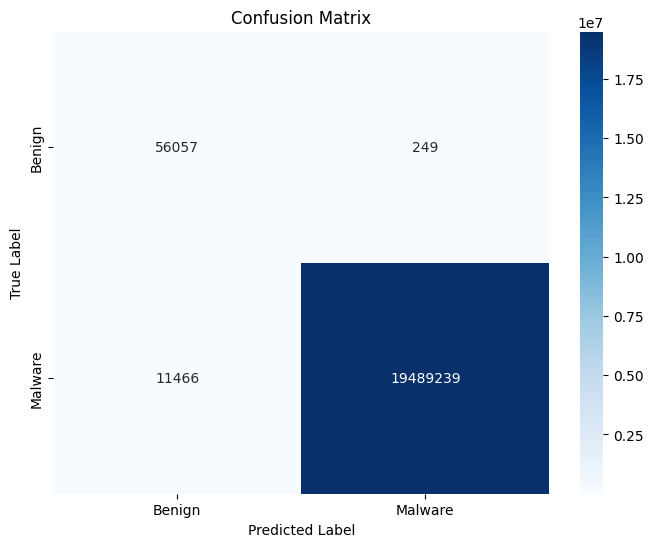

In [12]:
import torch
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Metti il modello in modalità di valutazione
model.eval()

# Variabili per tenere traccia delle predizioni e delle etichette reali
all_preds = []
all_labels = []
test_loss = 0.0

# Disattiva il calcolo dei gradienti
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test Progress", leave=False):
        images, labels = images.to(device), labels.to(device).float()
        
        # Ottieni le predizioni
        yhat = model(images).squeeze(1)
        
        # Calcola il loss
        loss = loss_fn(yhat, labels)
        test_loss += loss.item()
        
        # Applica una soglia di 0.5 per classificare come 0 o 1 (adatto per output di tipo sigmoid)
        preds = (yhat > 0.5).float()
        
        # Memorizza le predizioni e le etichette vere
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcola il loss medio sul test set
avg_test_loss = test_loss / len(test_loader)

# Calcola altre metriche
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)

# Stampa le metriche
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Calcola e visualizza la matrice di confusione
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')

#base_name = os.path.basename(nome_file)  # Ottiene 'LDAP.csv'
#name_without_ext = os.path.splitext(base_name)[0]  # Ottiene 'LDAP'
#output_file_name = f'confusion_matrix_{name_without_ext}.png'
output_file_name = f'confusion_matrix_test.png'
plt.savefig(output_file_name)
plt.show()